<a href="https://colab.research.google.com/github/samratbaral/shakespeare-language-model/blob/main/Shakespeare_%7C_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Using Pytorch: Karpathy Character-level RNN language models on shakespeare play/data**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Advantage of pytorch:

---
**Tensor**: Imperative N-Dimension Array Running on GPU. [Same Data Type]

**Variable**: Node in Computational Graph - to Store Data and Gradient

**Module**: Neural Network layer - Stores State or Learnable Weights

In [ ]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""

import torch                            # pyTorch library
import torch.nn as nn                   # Neural Network Model : Parent Objects
import torch.nn.functional as F         # Gives activation function to connect layers

from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import urllib.request                   # this would output the html source text
import requests                         # this request the url




#Prepare File
Text-File is opened and copied from Standford Library
[Source: Andrey Karpathy GitHub ]

*   **Read**:  text-file called "shakespear.txt"
*   **Variable** : data  
```
data = request.get(url)
file.write(data.text)
data = open('shakespear.txt', 'r').read()
```
then we open the data text file for reading

In [ ]:
#Fetching the data
#This is just reading the data from URL
with urllib.request.urlopen("https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt") as url:
    data = url.read()

#This is just Writing the data from URL to text file in the file system
uirllist = ["https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt" ]
for url in urllist:
    data = requests.get(url)
with open('shakespear.txt', 'w') as file:
        file.write(data.text)

#This is just reading the data from file system
data = open('shakespear.txt', 'r').read()
#is data a string? - print(data)
type(data)

if isinstance(data, str):
  print('Data is {}'.format(type(data)))

Data is <class 'str'>


#Prepare Data:
* Variable : **chars** [list each character in set]
* Variable : **data_size** [size character type in set]
* Variable : **vocab_size** [size unique type in set]
* Variable : **unique** [Format below]

```
print ('data has %d characters, %d unique.'% (data_size, vocab_size))
```





In [ ]:
#Describing the data
# data I/O above
# data = open('shakespear.txt', 'r').read() # should be simple plain text file

#the characters are indivudualized and listed in a set
chars = list(set(data))

# Size of characters and unique
data_size = len(data)
vocab_size = len(chars)
unique = "data has {} characters, {} unique."
print(unique.format(data_size, vocab_size))
#print ('data has %d characters, %d unique.'% (data_size, vocab_size))
print(chars)

data has 99993 characters, 62 unique.
['N', 'e', 'I', 'm', 'y', 'g', 'U', "'", 'o', 'b', 'x', 'B', 't', ';', 'k', 'K', 'q', 's', '!', 'R', 'u', 'D', ':', 'M', 'r', 'l', '.', 'S', 'i', '-', 'F', 'V', 'n', 'G', 'p', 'z', 'c', 'Y', 'O', ' ', 'C', 'A', 'Z', 'T', '\n', 'j', ',', 'P', 'f', 'Q', 'a', 'X', 'L', '?', 'v', 'E', 'h', 'w', 'd', 'W', 'J', 'H']


#Iteration Process
* Variable : **char_to_ix** [each character is iterate]
* Variable : **ix_to_char** [each iterate is character]
```
 " %c " = 0,1..n
 0,1..n = " %c "
```

* Variable : **hidden size** [size of hidden layer of neurons]
* Variable : **seq_length** [number of steps to unroll the RNN]
* Variable : **learning_rate** ```= 1e-1``` [Learning rate: **1 %** ]



In [ ]:
#Converting the data
#Iteration Process
char_to_ix = { ch:i for i,ch in enumerate(chars) }  # " %c " = 0,1..n
ix_to_char = { i:ch for i,ch in enumerate(chars) }  # 0,1..n = "%c"

#chars_tensor =
#F.one_hot()

print(char_to_ix)

# hyperparameters
# size of hidden layer of neurons
hidden_size = 100
# number of steps to unroll the RNN for
seq_length = 25

#The Learning rate :
#Which also match the autoencoder specification signal limiation 1% unlike
# our autoencoder which is 2%
# Batch: 1 iteration of forward & backward pass subset data: set of data
# epoch: All point used to compute loss :
# let (x) iteration x: #item/size(Batch)
# eg x = #1000/500 = 2 iteration  = 1 epoch

#learning 1%
learning_rate = 1e-1

{'N': 0, 'e': 1, 'I': 2, 'm': 3, 'y': 4, 'g': 5, 'U': 6, "'": 7, 'o': 8, 'b': 9, 'x': 10, 'B': 11, 't': 12, ';': 13, 'k': 14, 'K': 15, 'q': 16, 's': 17, '!': 18, 'R': 19, 'u': 20, 'D': 21, ':': 22, 'M': 23, 'r': 24, 'l': 25, '.': 26, 'S': 27, 'i': 28, '-': 29, 'F': 30, 'V': 31, 'n': 32, 'G': 33, 'p': 34, 'z': 35, 'c': 36, 'Y': 37, 'O': 38, ' ': 39, 'C': 40, 'A': 41, 'Z': 42, 'T': 43, '\n': 44, 'j': 45, ',': 46, 'P': 47, 'f': 48, 'Q': 49, 'a': 50, 'X': 51, 'L': 52, '?': 53, 'v': 54, 'E': 55, 'h': 56, 'w': 57, 'd': 58, 'W': 59, 'J': 60, 'H': 61}


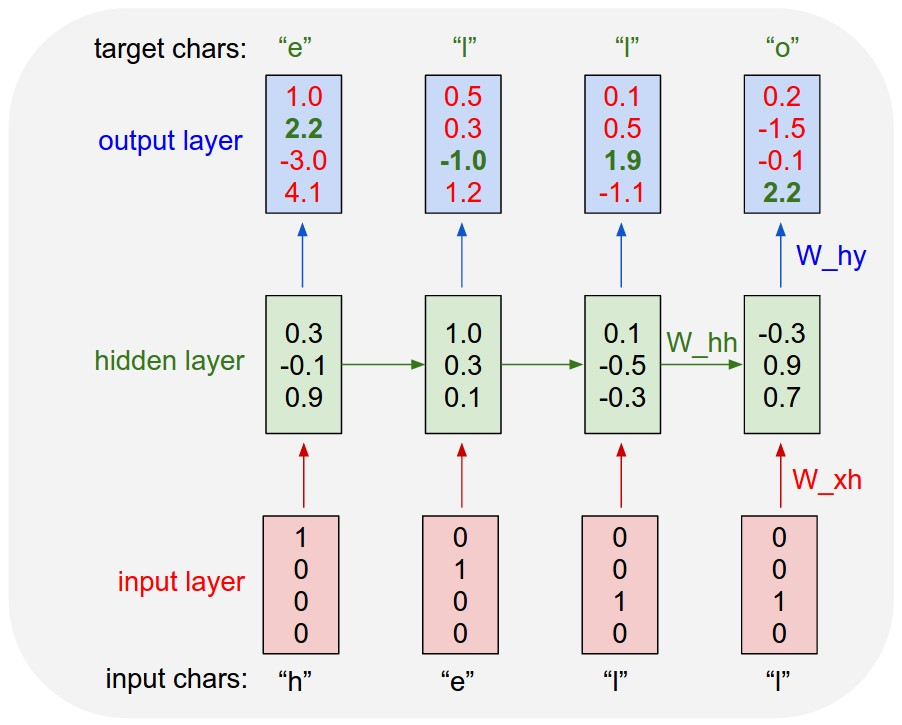

[Source: http://karpathy.github.io/assets/rnn/charseq.jpeg]

# RNN Model: Initialization Process
* Annotation: **W**: Weights
* Variable : **Wxh** >> **x** >> Initial Input
* Variable : **Whh** >> **h** >> Hidden State >> W from x to h
* Variable : **Why** >> **y** >> Transferring Output >> W from h to output
* Variable : **bh** [Hidden Bias ``= 1``]
* Variable : **by** [ Vocab Size ``= 1``]


In [ ]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01    # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01   # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01    # hidden to output
bh = np.zeros((hidden_size, 1))                        # hidden bias
by = np.zeros((vocab_size, 1))                         # output bias

## Build the RNN Model Class : Using Pytorch
This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$.

### There are three layers
- one linear layer that encodes the input character into an internal state
- internal state
    *    GRU layer (which may itself have multiple layers) that operates on that it.
      - Internal state
      - Hidden state
      - Decoder layer that outputs the probability distribution.

Expressing Neurial Netowork NN Code:

In [ ]:
# Create the pyTorch Class
# input
class RNN(torch.nn.Module): #inherits nn.module
    # dnt need n_layer  = 1 [update needed]

    def __init__(self, input_size, hidden_size, output_size):

        # Super Constructor
        super(RNN, self).__init__()

        # The super() builtin returns a proxy object
        # (temporary object of the superclass) that allows us to access methods of the base class.
#

        # 1 Input -> hidden layer -> output layer
        # We are defining the properties of a class as self.[something]
        # https://www.tutorialspoint.com/self-in-python-class
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Kernel : Runs Independently
        # Building Layer followed by activation function

        # Embedding module containing: Float (Default)
        #                         input size [value] of hidden size [Size]
        # https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

        self.encoder = nn.Embedding(input_size, hidden_size)

        # Gate Reccurrent Unit (gru): RNN input
        # function:
        # base case = 1 / hidden_size
        # Bidirection : - Batch [ Forward = 0 , Backward = 1] : Default [False]
        #                 [Batch: True ] [N  L  H ] N: Batch size
        #                 [Batch: False] [L  N  H ] L: Sequence Length
        #                                           H: input size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)

        # Building an linear encoder with Linear layer y = mc + c
        #                       [In Feature]  [Out Feature]
        self.decoder = nn.Linear(hidden_size, output_size)

    #self is object , input and Hidden is batch of data
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))





Model Initialization
model = RNN(vocab_size, hidden_size, output_size)
  
 Validation using MSE Loss function
loss = 0
 loss_function = torch.nn.MSELoss(inputs, targets, hprev)

Using an Adam Optimizer with lr = 0.1 (this helps in updating the weights)
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.1,
                             weight_decay = 1e-5)
 loss = nn.CrossEntropyLoss()
input = torch.randn(5, 7, requires_grad=True)
 target = torch.empty(5, dtype=torch.long).random_(5)
output = loss(input, target)
 output.backward()
 output

torch.nn.RNN
 nn.softmax()

At some point, we want the line:
 network = RNN(vocab_size, 100, output_size)

#**Forward Propgation**
[RNN only takes sequence of weights in the sequence]
* Variable: **t**   : Time Step : Works as a target key
* Variable: **xs**  : Dictionary : Input Stage
* Variable: **hs**  : Dictionary : Copy Previous Hidden Stage
* Variable: **ys**  : Dictionary : Output Stage
* Variable: **ps**  : Dictionary : Probality of next Character
* Variable: **loss**: Calculate the Loss   
* Variable: **dWxh**:
* Variable: **dWhh**:
* Variable: **dWhy**:


In [ ]:


def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0

  #zs = F.one_hot(torch.arange(0, vocab_size), num_classes = vocab_size)
  #xs = { ch:zs[i] for ch,i in len(chars)}  # " %c " = 0,1..n
  #ix_to_char = { i:ch for i,ch in enumerate(chars) }  # 0,1..n = "%c"

  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars

    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars

    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)


  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])


  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)


  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients


  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]


def sample(h, seed_ix, n):
  """
  sample a sequence of integers from the model
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

n, p = 0, 0
x_axis, y_axis = [], []
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0:
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  if n < 5:
    print("Input"+str(n)+": "+str(inputs))
    print("Target"+str(n)+": "+str(targets))

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    print("Output: "+str(sample_ix))
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    output = '----\n {} \n----'
    print(output.format(txt))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  hundred_check = 'iter {}, loss: {}'
  if n % 100 == 0:
    print(hundred_check.format(n, smooth_loss)) # print progress

    #prepare iteration-vs-loss plot

    x_axis.append(n)
    y_axis.append(smooth_loss)

  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                [dWxh, dWhh, dWhy, dbh, dby],
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter

Streaming output truncated to the last 5000 lines.
If orse
An of they expull of he will,
But you grack.

ANNO:
WiS with be are your go'ly
thAst and hers 
----
iter 1212100, loss: 42.66887228149756
Output: [58, 39, 5, 8, 26, 44, 44, 27, 41, 41, 27, 39, 55, 23, 2, 19, 55, 22, 44, 2, 7, 58, 25, 50, 14, 46, 39, 2, 39, 36, 50, 32, 17, 17, 1, 39, 9, 1, 26, 44, 44, 21, 41, 41, 0, 38, 30, 39, 27, 39, 47, 38, 24, 57, 50, 32, 5, 50, 9, 17, 39, 8, 48, 39, 32, 8, 39, 17, 56, 8, 57, 39, 1, 25, 1, 26, 44, 44, 61, 55, 27, 27, 2, 6, 27, 22, 44, 2, 39, 12, 50, 14, 1, 39, 54, 28, 36, 56, 17, 17, 44, 59, 56, 50, 12, 44, 61, 1, 17, 12, 39, 12, 56, 24, 1, 12, 39, 12, 56, 28, 17, 39, 17, 12, 50, 4, 39, 56, 1, 50, 54, 39, 1, 54, 1, 3, 46, 39, 12, 56, 1, 1, 46, 39, 20, 34, 8, 32, 18, 39, 3, 4, 39, 2, 39, 34, 8, 8, 14, 39, 57, 50, 3, 1, 39, 9, 4, 39, 57, 1, 25, 25, 22, 39, 12, 56, 1, 39, 36, 8, 17, 1, 39, 9, 24, 8, 57, 17, 39, 17, 8, 26, 44, 44, 41, 0, 19, 37, 22, 44]
----
 d go.

SAAS EMIRE:
I'dlak, I cansse 